In [80]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os

In [81]:
%matplotlib inline

## Constants

In [82]:
IMG_WIDTH = 32
IMG_HEIGHT = 32

## Data loading

In [83]:
def load_data(data_dir):
    images = []
    labels = []

    def fast_scandir(dirname):
        subfolders = [f.path for f in os.scandir(dirname) if f.is_dir()]
        for dirname in list(subfolders):
            subfolders.extend(fast_scandir(dirname))
        return subfolders

    directories = fast_scandir(data_dir)
    for directory in directories:
        files = os.listdir(directory)
        class_id = int(directory.split("/")[-1])
        for file in files:
            filepath = os.path.join(directory, file)
            image = cv2.imread(filepath)
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            images.append(image)
            labels.append(class_id)

    return images, labels

In [84]:
import cv2

images_path = "gtsrb"

# Get image arrays and labels for all image files
images, labels = load_data(images_path)

# Split data into training and testing sets
labels = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(
    np.array(images), np.array(labels), test_size=0.2,
    shuffle=True
)    

In [85]:
NUM_CATEGORIES = labels.shape[1]

## Class names

In [86]:
class_names = {0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right',
 39: 'Keep left',
 40: 'Roundabout mandatory',
 41: 'End of no passing',
 42: 'End of passing by vehicles over 3.5 metric tons'}

In [87]:
class_counter = labels.sum(axis=0)

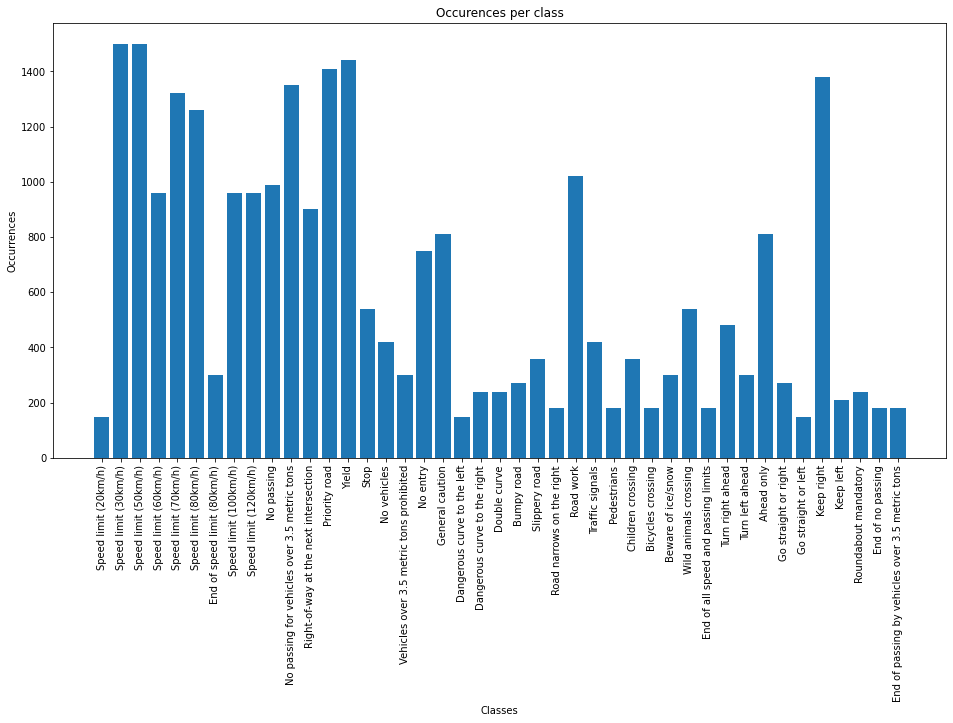

In [88]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.bar(class_names.values(), class_counter)
plt.title("Occurences per class")
plt.xticks(rotation=90)
plt.xlabel('Classes')
plt.ylabel('Occurrences')
plt.show()

In [89]:
class_counter_dict = {idx: x for idx, x in enumerate(class_counter)}

In [90]:
class_counter_dict =  dict(sorted(class_counter_dict.items(), key=lambda item: item[1], reverse=True))

In [91]:
print("Times each class appears in order")
print("------------------------------------------------------------")
for key, values in class_counter_dict.items():
    print(f"{class_names[key]:50} ===> {int(values):4}")

Times each class appears in order
------------------------------------------------------------
Speed limit (30km/h)                               ===> 1500
Speed limit (50km/h)                               ===> 1500
Yield                                              ===> 1440
Priority road                                      ===> 1410
Keep right                                         ===> 1380
No passing for vehicles over 3.5 metric tons       ===> 1350
Speed limit (70km/h)                               ===> 1320
Speed limit (80km/h)                               ===> 1260
Road work                                          ===> 1020
No passing                                         ===>  990
Speed limit (60km/h)                               ===>  960
Speed limit (100km/h)                              ===>  960
Speed limit (120km/h)                              ===>  960
Right-of-way at the next intersection              ===>  900
General caution                                    

## How does each class class_name looks like

In [92]:
def divide_text(txt):
    if len(txt) > 20:
        return txt[:20] + txt[20:].replace(" ", "\n", 1)
    return txt

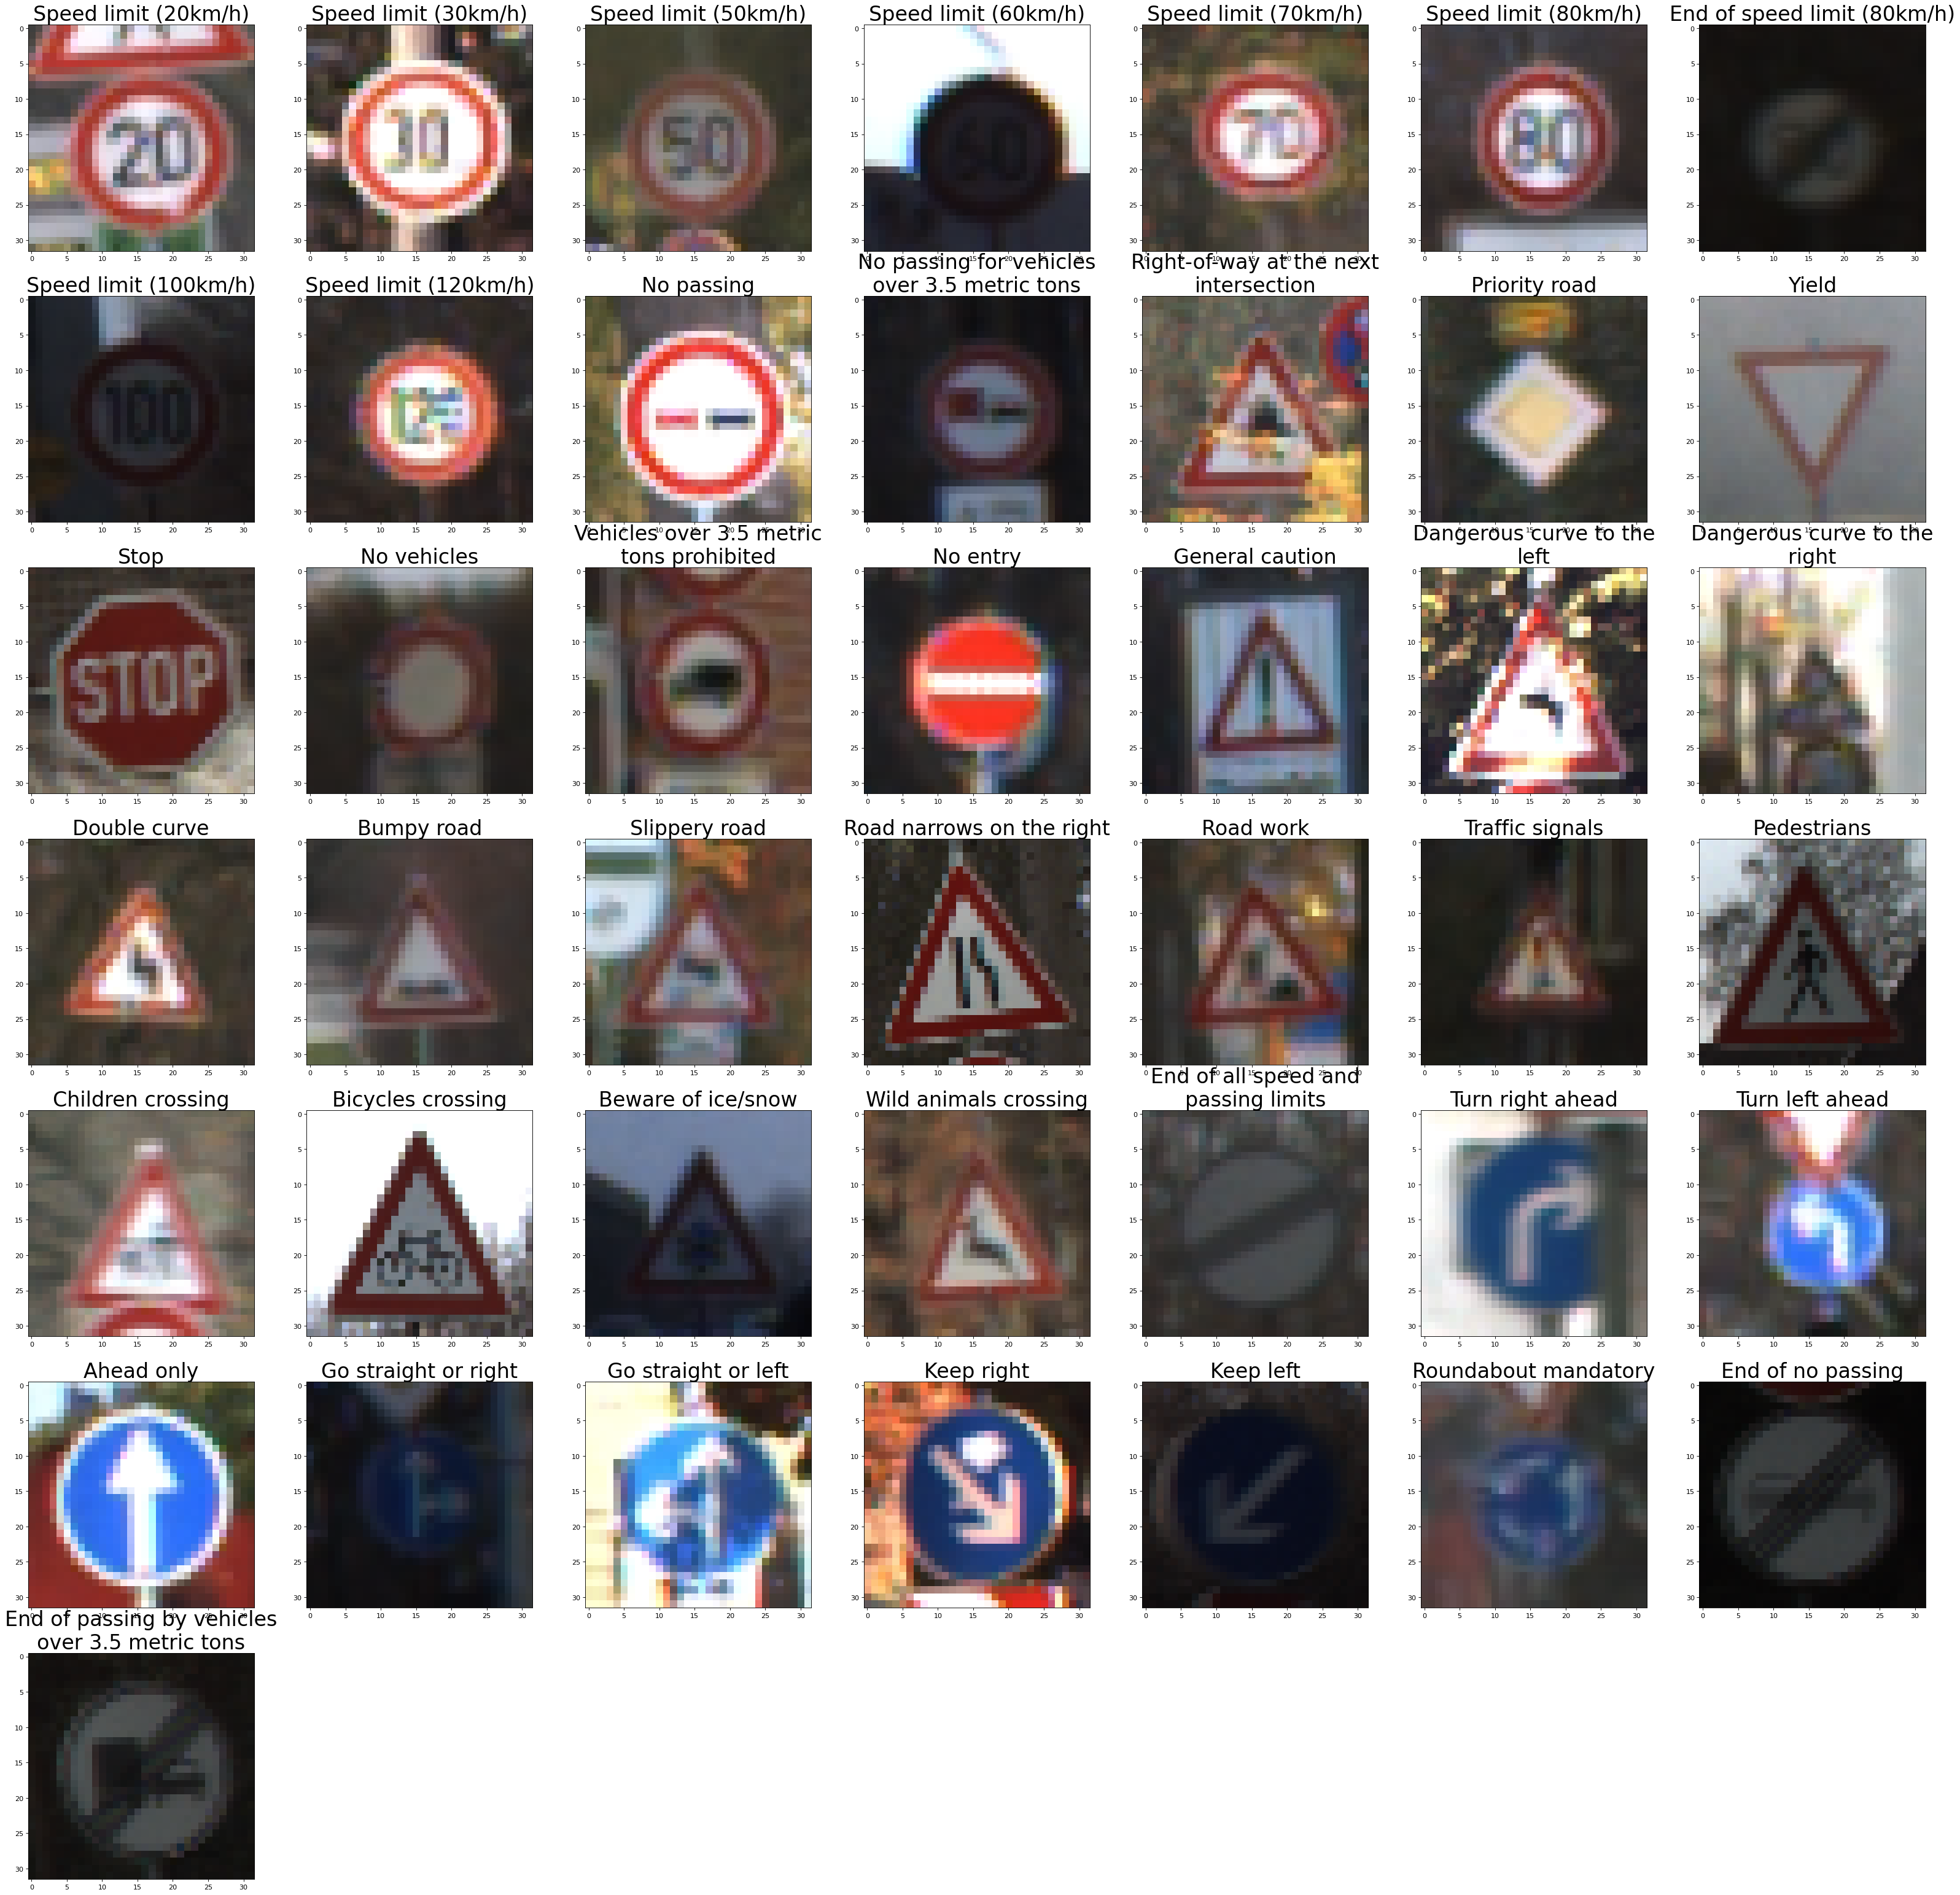

In [93]:
plt.figure(figsize=(50, 50), dpi= 80, facecolor='w', edgecolor='k')

for i, class_name in class_names.items():
    first_image_of_class_index = list(labels[:, i]).index(1)
    plt.subplot(7, 7, i + 1)
    plt.imshow(images[first_image_of_class_index][:,:,::-1])
    plt.title(divide_text(class_name), fontsize=30)

In [94]:
tf.keras.backend.set_image_data_format('channels_last')

In [95]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. When building a new Sequential architecture, it's useful to incrementally stack layers with add() and frequently print model summaries. 

Conv2D: This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.

MaxPooling2D: Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

Dropout: randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [101]:
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3),
                         input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
                         activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CATEGORIES, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])
    return model

In [160]:
def lr_schedule(lr, epoch):
    divide_by = 10 ** (1 + epoch // 10)
    return lr/divide_by

In [112]:
model = create_model()
model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

In [113]:
batch_size = 32
nb_epoch = 20 

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          callbacks = [LearningRateScheduler(lr_schedule), 
                       ModelCheckpoint('model.h5', save_best_only=True)]
          shuffle=True)

Epoch 1/20
533/533 [==============================] - 7s 13ms/step - loss: 3.1484 - accuracy: 0.5358 - val_loss: 0.5543 - val_accuracy: 0.8693
Epoch 2/20
533/533 [==============================] - 7s 13ms/step - loss: 0.6914 - accuracy: 0.8194 - val_loss: 0.3332 - val_accuracy: 0.9245
Epoch 3/20
533/533 [==============================] - 7s 13ms/step - loss: 0.4425 - accuracy: 0.8799 - val_loss: 0.2404 - val_accuracy: 0.9475
Epoch 4/20
533/533 [==============================] - 7s 13ms/step - loss: 0.3474 - accuracy: 0.9065 - val_loss: 0.1652 - val_accuracy: 0.9634
Epoch 5/20
533/533 [==============================] - 7s 13ms/step - loss: 0.2856 - accuracy: 0.9239 - val_loss: 0.1593 - val_accuracy: 0.9622
Epoch 6/20
533/533 [==============================] - 7s 13ms/step - loss: 0.2742 - accuracy: 0.9289 - val_loss: 0.1368 - val_accuracy: 0.9711
Epoch 7/20
533/533 [==============================] - 7s 13ms/step - loss: 0.1850 - accuracy: 0.9513 - val_loss: 0.1097 - val_accuracy: 0.9779

In [114]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 flatten_14 (Flatten)        (None, 6272)              0         
                                                                 
 dense_27 (Dense)            (None, 512)               3211776   
                                                     

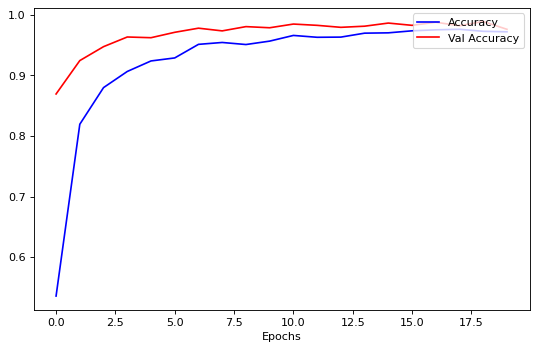

In [115]:
plt.figure(figsize=(8, 5), dpi= 80)
plt.plot(history.history['accuracy'],"b",label="Accuracy") 
plt.plot(history.history['val_accuracy'],"r",label="Val Accuracy") 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.show()

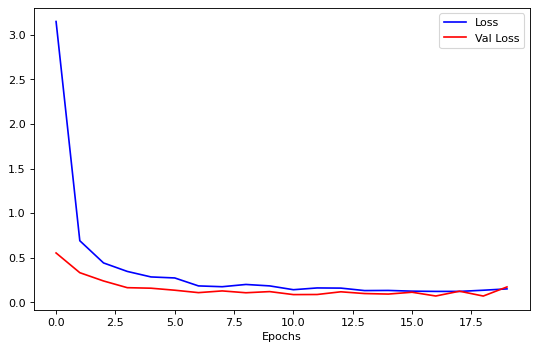

In [116]:
plt.figure(figsize=(8, 5), dpi= 80)
plt.plot(history.history['loss'],"b",label="Loss") 
plt.plot(history.history['val_loss'],"r",label="Val Loss") 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.show()

## Metrics

In [118]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [119]:
y_pred = model.predict(x_test) #The predicted labels
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)

acc = accuracy_score(y_test_classes, y_pred_classes)
print("Test accuracy = {}".format(acc))  

167/167 [==============================] - 1s 3ms/step
Test accuracy = 0.9744744744744744


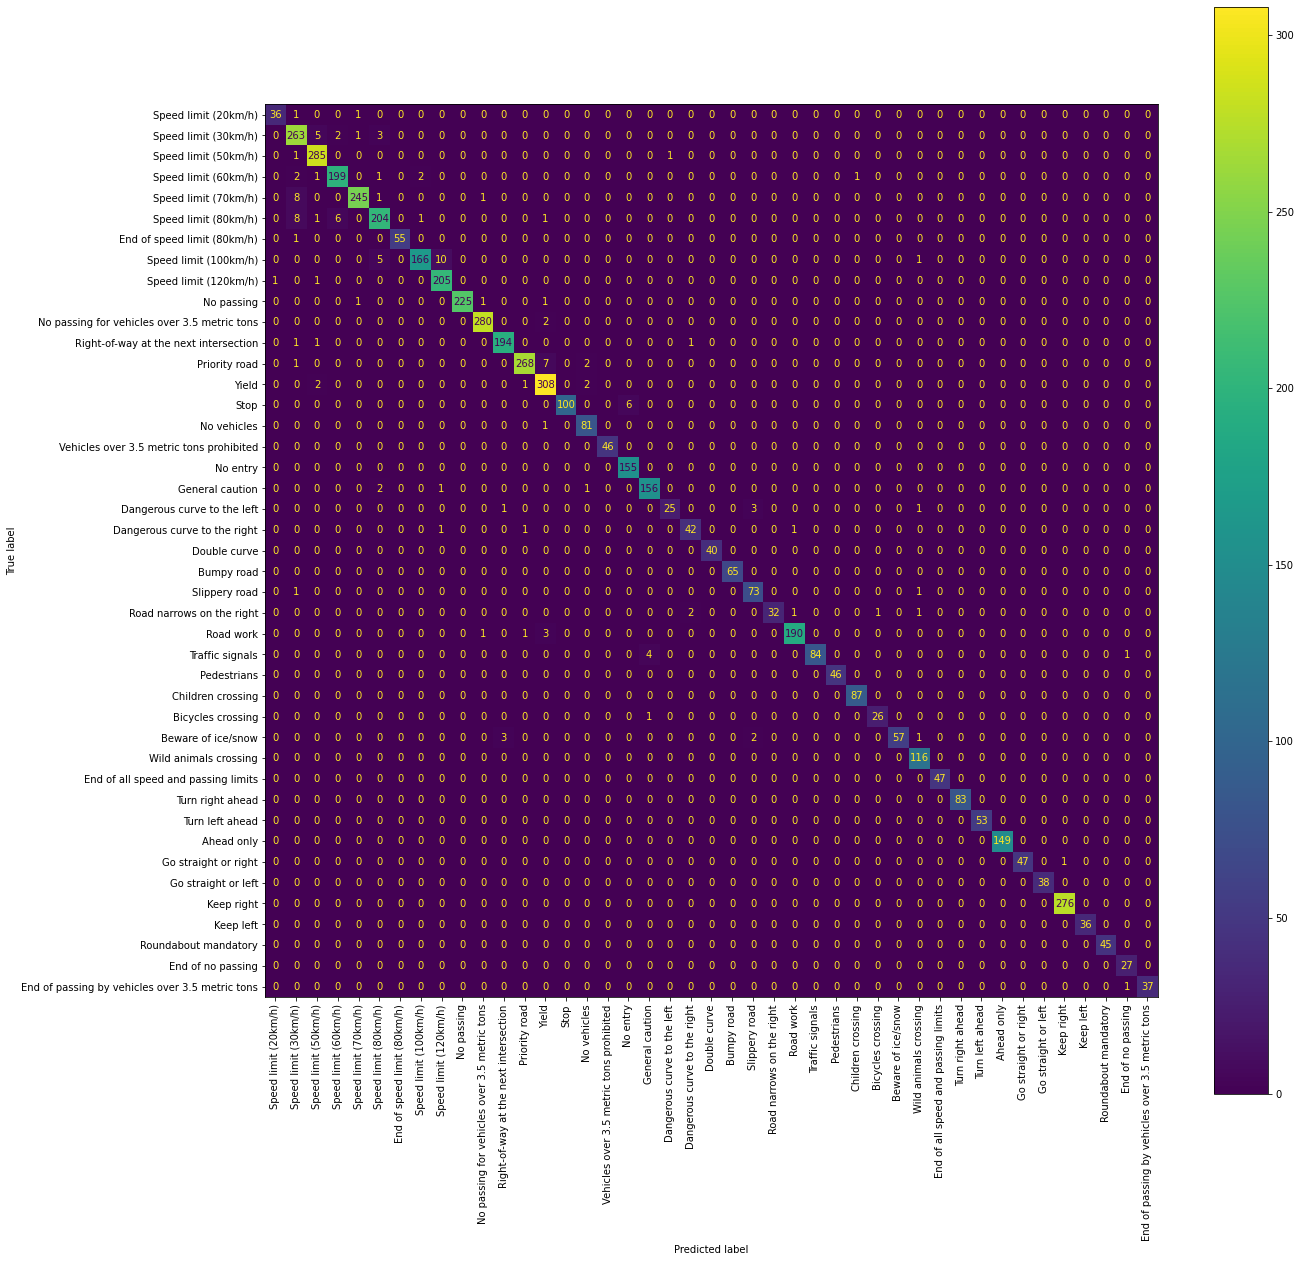

In [120]:
fig, ax = plt.subplots(figsize=(20,20))
cm=confusion_matrix(y_test_classes, y_pred_classes) #We create the confusion matrix, we feed it with the real labels and 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names.values())
disp.plot(ax=ax)
plt.xticks(rotation=90);
# disp.im_.colorbar.remove()

### See where the model made a mistake

In [121]:
missed_prediction_indixes = np.where(~(y_test_classes == y_pred_classes))[0]

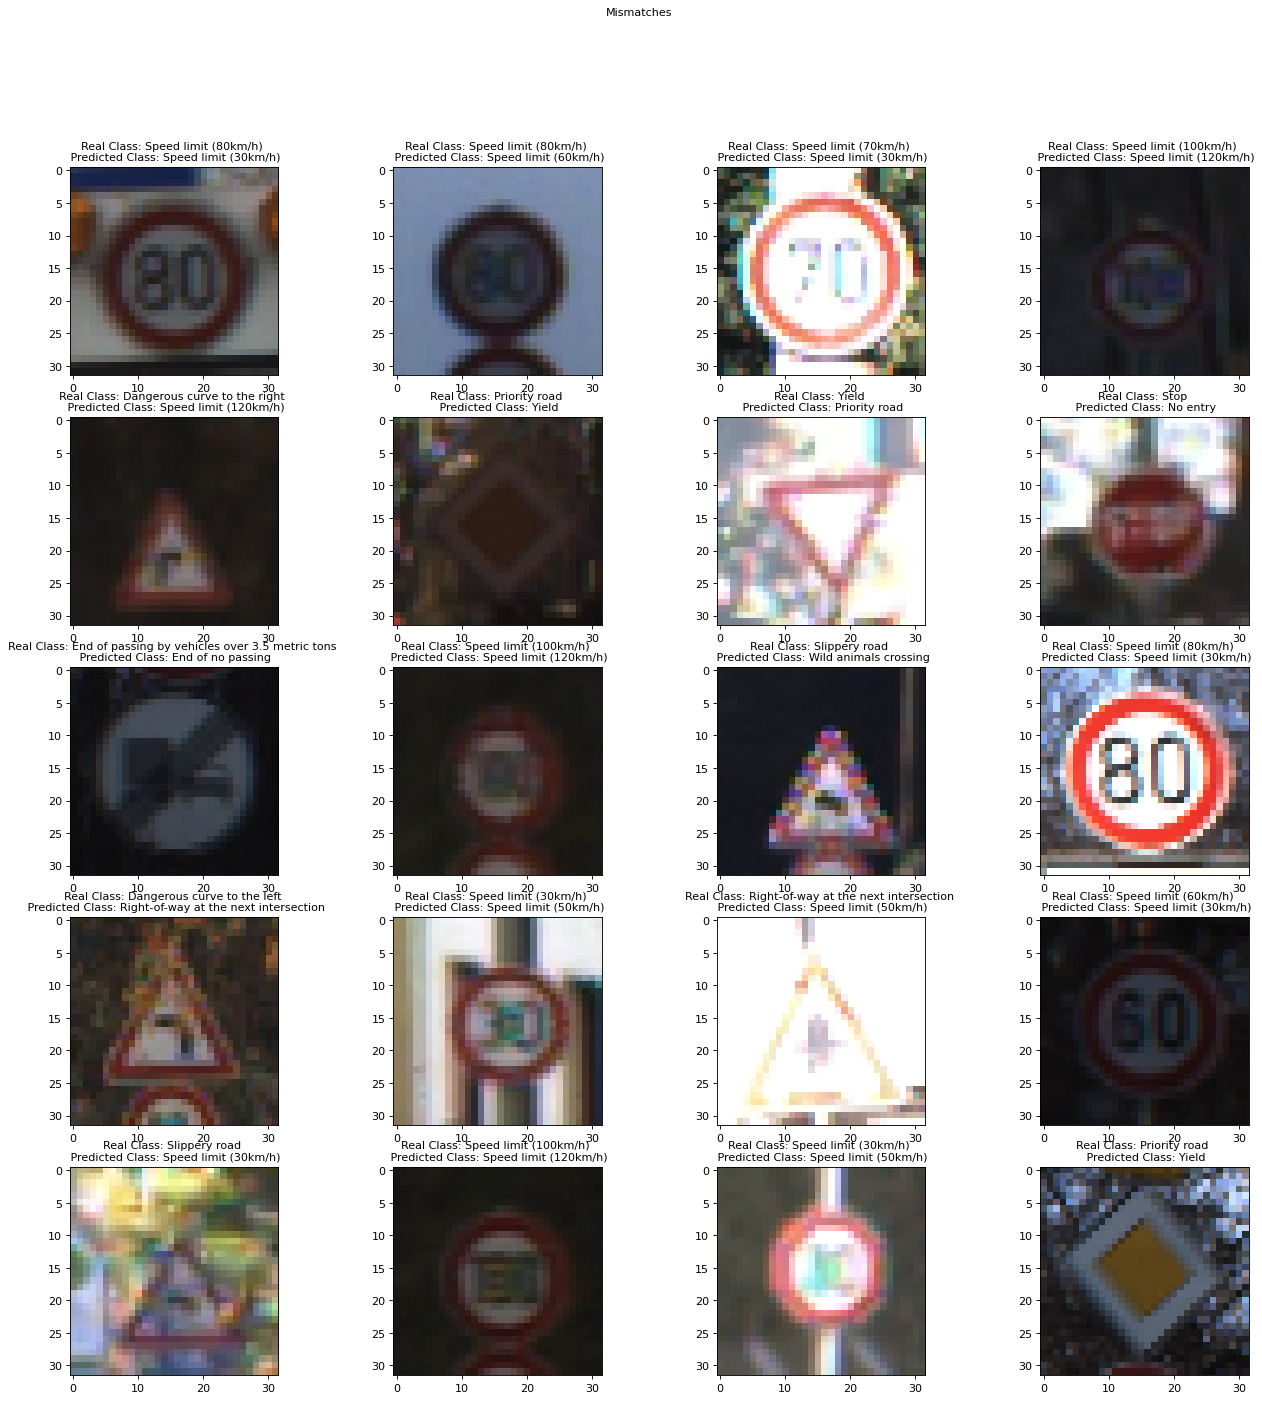

In [122]:
plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for idx, idx_image in enumerate(missed_prediction_indixes[:20]):
    plt.subplot(5, 4, idx + 1)
    plt.imshow(x_test[idx_image][:,:,::-1])
    plt.title(f"Real Class: {class_names[y_test_classes[idx_image]]} \n Predicted Class: {class_names[y_pred_classes[idx_image]]}", fontsize=10)
plt.suptitle("Mismatches",fontsize=10)
plt.show()

# Approach 2. Transfer Learning

In [54]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [59]:
IMG_WIDTH = 32
IMG_HEIGHT = 32

In [130]:
import cv2

images_path = "gtsrb"

# Get image arrays and labels for all image files
images, labels = load_data(images_path)

# Split data into training and testing sets
labels = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(
    np.array(images), np.array(labels), test_size=0.2,
    shuffle=True
)

In [132]:
x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test = tf.keras.applications.resnet50.preprocess_input(x_test)

In [133]:
# ADD PREPROCESSING

In [134]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = tf.keras.Sequential([base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
])

In [145]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

In [146]:
batch_size = 32
nb_epoch = 5

# This model was trained 10 epochs on a lr 10 times bigger. Now we finetune it training it
# 5 more epochs on a lr of 0.0001

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks = [LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model_resnet.h5', save_best_only=True)])

Epoch 1/5
666/666 [==============================] - 88s 128ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0188 - val_accuracy: 0.9966 - lr: 1.0000e-04
Epoch 2/5
666/666 [==============================] - 85s 128ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0203 - val_accuracy: 0.9962 - lr: 1.0000e-04
Epoch 3/5
666/666 [==============================] - 86s 128ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0240 - val_accuracy: 0.9953 - lr: 1.0000e-04
Epoch 4/5
666/666 [==============================] - 86s 129ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0221 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 5/5
666/666 [==============================] - 84s 126ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0215 - val_accuracy: 0.9961 - lr: 1.0000e-04


## Metrics

In [147]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [148]:
y_pred = model.predict(x_test) #The predicted labels
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)

acc = accuracy_score(y_test_classes, y_pred_classes)
print("Test accuracy = {}".format(acc))  

167/167 [==============================] - 6s 31ms/step
Test accuracy = 0.9960585585585585


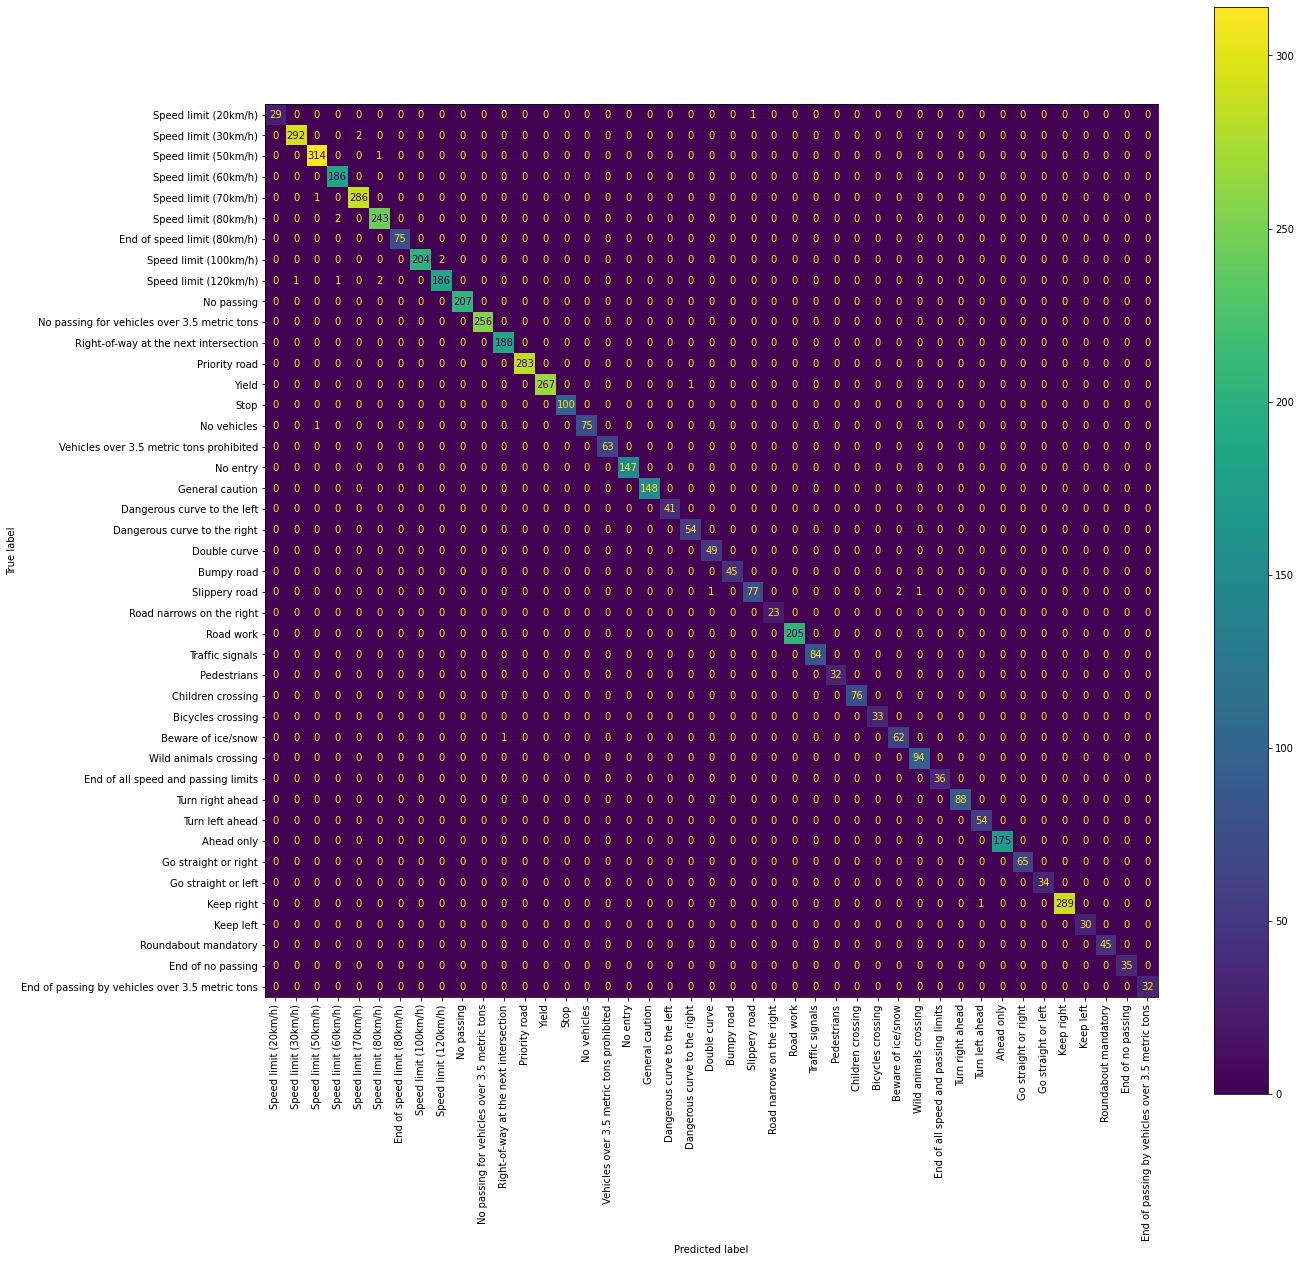

In [149]:
fig, ax = plt.subplots(figsize=(20,20))
cm=confusion_matrix(y_test_classes, y_pred_classes) #We create the confusion matrix, we feed it with the real labels and 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names.values())
disp.plot(ax=ax)
plt.xticks(rotation=90);
# disp.im_.colorbar.remove()